In [19]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms.v2 as v2
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn
from pathlib import Path

import models.MathNet as mnt
import models.MathNet20 as mnt20
import models.MathNet112 as mnt112

In [20]:
BATCH_SIZE = 160
EPOCHS = 31
IMAGE_SIZE = 224

In [21]:
def add_contrast(x):
    return transforms.functional.adjust_contrast(x, 14.5)

In [22]:
def add_padding(x):
    return transforms.functional.pad(x, IMAGE_SIZE//2 - x.size[0] // 2, 255.0, 'constant')

In [23]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    v2.RandomApply(
    torch.nn.ModuleList([
        v2.RandomResize(IMAGE_SIZE//2, IMAGE_SIZE+100),
        v2.Pad(12, 255., 'constant'),]), 
        p=0.3)
    ,
    #add_padding,
    #v2.RandomZoomOut(255.0, (1, 1.5), 0.5),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    #transforms.Normalize(std=0.5, mean=0.2)
    
])
# the validation transforms
valid_transform = v2.Compose([
    v2.Grayscale(1),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor()
])

e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [24]:
dataset = torchvision.datasets.ImageFolder(r'G:\\TRAIN\images_contrast_to'+str(IMAGE_SIZE), transform=train_transform)
print(len(dataset))

136113


In [25]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'F',
 'I-',
 'alpha',
 'and',
 'beta',
 'delta',
 'equal',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z',
 'Г']

In [26]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

44

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [28]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.9714) tensor(0.1641)


In [29]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(
        list(range(len(dataset))), 
        test_size=val_split,
        stratify=dataset.targets,
        )
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [30]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
27223


In [31]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 136113
    Root location: G:\\TRAIN\images_contrast_to224
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


27223
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) torch.Size([1, 224, 224])


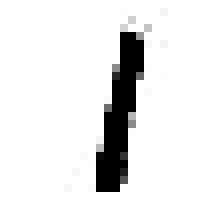

In [32]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders

train_dataset
print(len(valid_dataset))
print(valid_dataset[15551][0], valid_dataset[15551][0].shape)
#print(valid_dataset.dataset.targets)
aaa = v2.ToPILImage()
display(aaa(valid_dataset.dataset[16000][0]))

In [33]:
from collections import Counter
#train_classes = [label for _, label in valid_dataset]
#Counter(train_classes)
train_classes = [dataset.targets[i] for i in train_dataset.indices]
valid_classes = [dataset.targets[i] for i in valid_dataset.indices]
print(Counter(train_classes))
print(Counter(valid_classes))


Counter({34: 2845, 21: 2717, 30: 2686, 29: 2674, 33: 2658, 41: 2645, 17: 2630, 35: 2629, 15: 2621, 25: 2621, 19: 2605, 42: 2603, 8: 2592, 10: 2591, 39: 2587, 23: 2578, 3: 2578, 12: 2572, 38: 2563, 2: 2558, 40: 2558, 27: 2551, 5: 2549, 28: 2548, 0: 2539, 1: 2539, 4: 2535, 32: 2534, 26: 2518, 13: 2510, 14: 2510, 11: 2500, 9: 2499, 16: 2495, 6: 2491, 7: 2491, 20: 2467, 18: 2458, 31: 2352, 24: 2265, 43: 2231, 22: 1502, 36: 1470, 37: 1225})
Counter({34: 711, 21: 679, 30: 672, 29: 668, 33: 665, 41: 661, 17: 658, 35: 657, 15: 655, 25: 655, 19: 651, 42: 651, 10: 648, 8: 648, 39: 647, 23: 644, 3: 644, 12: 643, 38: 641, 40: 640, 2: 640, 27: 638, 28: 637, 5: 637, 1: 635, 0: 635, 32: 634, 4: 634, 26: 630, 14: 628, 13: 627, 11: 625, 9: 625, 16: 624, 6: 623, 7: 623, 20: 616, 18: 614, 31: 588, 24: 566, 43: 558, 22: 375, 36: 367, 37: 306})


In [34]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 3174, 1: 3174, 2: 3198, 3: 3222, 4: 3169, 5: 3186, 6: 3114, 7: 3114, 8: 3240, 9: 3124, 10: 3239, 11: 3125, 12: 3215, 13: 3137, 14: 3138, 15: 3276, 16: 3119, 17: 3288, 18: 3072, 19: 3256, 20: 3083, 21: 3396, 22: 1877, 23: 3222, 24: 2831, 25: 3276, 26: 3148, 27: 3189, 28: 3185, 29: 3342, 30: 3358, 31: 2940, 32: 3168, 33: 3323, 34: 3556, 35: 3286, 36: 1837, 37: 1531, 38: 3204, 39: 3234, 40: 3198, 41: 3306, 42: 3254, 43: 2789}


<Axes: ylabel='Сharactrs'>

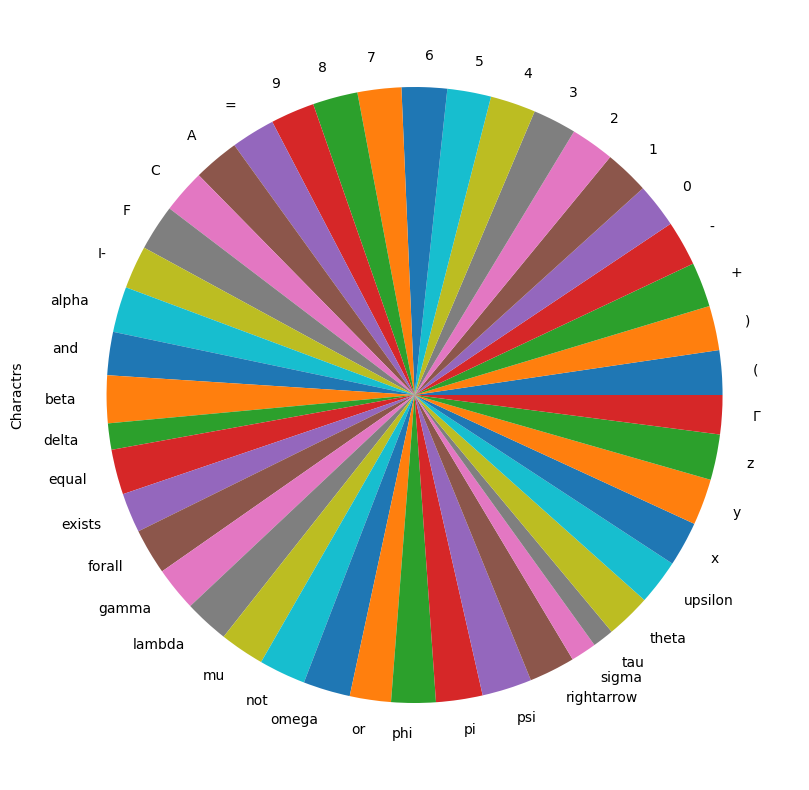

In [35]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [36]:
# for i, data in tqdm(enumerate(train_loader), total=int(len(train_loader))):
#     print(i)

In [37]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [38]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [39]:
if (IMAGE_SIZE == 112):
    model = mnt112.MathNet112()
elif (IMAGE_SIZE == 224):
    model = mnt.MathNet()

#model = mnt112.MathNet112()

print(mnt.NUM_CLASSES)

torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

44


models.MathNet.MathNet

In [40]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [41]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    Path('outputs').mkdir(parents=True, exist_ok=True)
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_loss'+label+'.png')

[INFO]: Epoch 1 of 31
Training


100%|██████████| 681/681 [02:45<00:00,  4.12it/s]


Validation


100%|██████████| 171/171 [00:35<00:00,  4.78it/s]


Training loss: 0.434, training acc: 90.240
Validation loss: 0.157, validation acc: 96.055
--------------------------------------------------
[INFO]: Epoch 2 of 31
Training


100%|██████████| 681/681 [02:14<00:00,  5.04it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.90it/s]


Training loss: 0.098, training acc: 97.637
Validation loss: 0.126, validation acc: 96.492
--------------------------------------------------
[INFO]: Epoch 3 of 31
Training


100%|██████████| 681/681 [02:15<00:00,  5.02it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.41it/s]


Training loss: 0.071, training acc: 98.212
Validation loss: 0.085, validation acc: 97.675
--------------------------------------------------
[INFO]: Epoch 4 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.90it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.42it/s]


Training loss: 0.060, training acc: 98.448
Validation loss: 0.080, validation acc: 97.756
--------------------------------------------------
[INFO]: Epoch 5 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.90it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.25it/s]


Training loss: 0.050, training acc: 98.670
Validation loss: 0.063, validation acc: 98.277
--------------------------------------------------
[INFO]: Epoch 6 of 31
Training


100%|██████████| 681/681 [02:18<00:00,  4.91it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.34it/s]


Training loss: 0.045, training acc: 98.791
Validation loss: 0.053, validation acc: 98.652
--------------------------------------------------
[INFO]: Epoch 7 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.88it/s]


Validation


100%|██████████| 171/171 [00:12<00:00, 14.22it/s]


Training loss: 0.041, training acc: 98.899
Validation loss: 0.068, validation acc: 98.171
--------------------------------------------------
[INFO]: Epoch 8 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.89it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.29it/s]


Training loss: 0.037, training acc: 99.001
Validation loss: 0.068, validation acc: 98.229
--------------------------------------------------
[INFO]: Epoch 9 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.86it/s]


Validation


100%|██████████| 171/171 [00:12<00:00, 14.25it/s]


Training loss: 0.032, training acc: 99.139
Validation loss: 0.060, validation acc: 98.439
--------------------------------------------------
[INFO]: Epoch 10 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.88it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.32it/s]


Training loss: 0.031, training acc: 99.162
Validation loss: 0.054, validation acc: 98.549
--------------------------------------------------
[INFO]: Epoch 11 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.89it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.36it/s]


Training loss: 0.026, training acc: 99.283
Validation loss: 0.053, validation acc: 98.648
--------------------------------------------------
[INFO]: Epoch 12 of 31
Training


100%|██████████| 681/681 [02:18<00:00,  4.92it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.74it/s]


Training loss: 0.025, training acc: 99.306
Validation loss: 0.057, validation acc: 98.509
--------------------------------------------------
[INFO]: Epoch 13 of 31
Training


100%|██████████| 681/681 [02:14<00:00,  5.08it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.98it/s]


Training loss: 0.021, training acc: 99.435
Validation loss: 0.041, validation acc: 98.942
--------------------------------------------------
[INFO]: Epoch 14 of 31
Training


100%|██████████| 681/681 [02:14<00:00,  5.08it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.93it/s]


Training loss: 0.021, training acc: 99.422
Validation loss: 0.054, validation acc: 98.516
--------------------------------------------------
[INFO]: Epoch 15 of 31
Training


100%|██████████| 681/681 [02:14<00:00,  5.08it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.97it/s]


Training loss: 0.019, training acc: 99.491
Validation loss: 0.050, validation acc: 98.667
--------------------------------------------------
[INFO]: Epoch 16 of 31
Training


100%|██████████| 681/681 [02:13<00:00,  5.09it/s]


Validation


100%|██████████| 171/171 [00:12<00:00, 14.14it/s]


Training loss: 0.018, training acc: 99.491
Validation loss: 0.064, validation acc: 98.207
--------------------------------------------------
[INFO]: Epoch 17 of 31
Training


100%|██████████| 681/681 [02:16<00:00,  4.99it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.64it/s]


Training loss: 0.015, training acc: 99.607
Validation loss: 0.046, validation acc: 98.905
--------------------------------------------------
[INFO]: Epoch 18 of 31
Training


100%|██████████| 681/681 [02:18<00:00,  4.93it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.72it/s]


Training loss: 0.015, training acc: 99.552
Validation loss: 0.042, validation acc: 99.049
--------------------------------------------------
[INFO]: Epoch 19 of 31
Training


100%|██████████| 681/681 [02:15<00:00,  5.03it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.67it/s]


Training loss: 0.012, training acc: 99.682
Validation loss: 0.043, validation acc: 99.008
--------------------------------------------------
[INFO]: Epoch 20 of 31
Training


100%|██████████| 681/681 [02:15<00:00,  5.03it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.73it/s]


Training loss: 0.014, training acc: 99.601
Validation loss: 0.042, validation acc: 98.997
--------------------------------------------------
[INFO]: Epoch 21 of 31
Training


100%|██████████| 681/681 [02:15<00:00,  5.02it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.63it/s]


Training loss: 0.011, training acc: 99.682
Validation loss: 0.049, validation acc: 98.799
--------------------------------------------------
[INFO]: Epoch 22 of 31
Training


100%|██████████| 681/681 [02:16<00:00,  5.00it/s]


Validation


100%|██████████| 171/171 [00:15<00:00, 10.88it/s]


Training loss: 0.011, training acc: 99.677
Validation loss: 0.045, validation acc: 98.960
--------------------------------------------------
[INFO]: Epoch 23 of 31
Training


100%|██████████| 681/681 [02:17<00:00,  4.96it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.37it/s]


Training loss: 0.011, training acc: 99.683
Validation loss: 0.049, validation acc: 98.817
--------------------------------------------------
[INFO]: Epoch 24 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.89it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.98it/s]


Training loss: 0.007, training acc: 99.813
Validation loss: 0.048, validation acc: 98.931
--------------------------------------------------
[INFO]: Epoch 25 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.88it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.74it/s]


Training loss: 0.009, training acc: 99.770
Validation loss: 0.043, validation acc: 99.060
--------------------------------------------------
[INFO]: Epoch 26 of 31
Training


100%|██████████| 681/681 [02:14<00:00,  5.07it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.97it/s]


Training loss: 0.009, training acc: 99.742
Validation loss: 0.130, validation acc: 96.852
--------------------------------------------------
[INFO]: Epoch 27 of 31
Training


100%|██████████| 681/681 [02:14<00:00,  5.08it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.40it/s]


Training loss: 0.009, training acc: 99.722
Validation loss: 0.042, validation acc: 99.052
--------------------------------------------------
[INFO]: Epoch 28 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.89it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.42it/s]


Training loss: 0.007, training acc: 99.812
Validation loss: 0.047, validation acc: 98.916
--------------------------------------------------
[INFO]: Epoch 29 of 31
Training


100%|██████████| 681/681 [02:19<00:00,  4.88it/s]


Validation


100%|██████████| 171/171 [00:12<00:00, 14.23it/s]


Training loss: 0.006, training acc: 99.839
Validation loss: 0.049, validation acc: 98.927
--------------------------------------------------
[INFO]: Epoch 30 of 31
Training


100%|██████████| 681/681 [02:18<00:00,  4.92it/s]


Validation


100%|██████████| 171/171 [00:11<00:00, 14.73it/s]


Training loss: 0.009, training acc: 99.772
Validation loss: 0.055, validation acc: 98.711
--------------------------------------------------
[INFO]: Epoch 31 of 31
Training


100%|██████████| 681/681 [02:17<00:00,  4.97it/s]


Validation


100%|██████████| 171/171 [00:12<00:00, 14.17it/s]


Training loss: 0.007, training acc: 99.806
Validation loss: 0.045, validation acc: 98.957
--------------------------------------------------
TRAINING COMPLETE


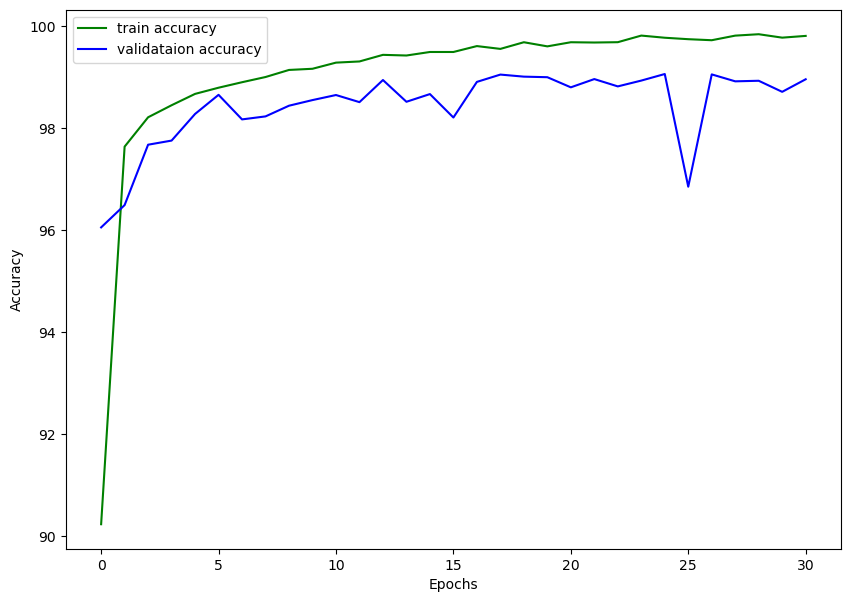

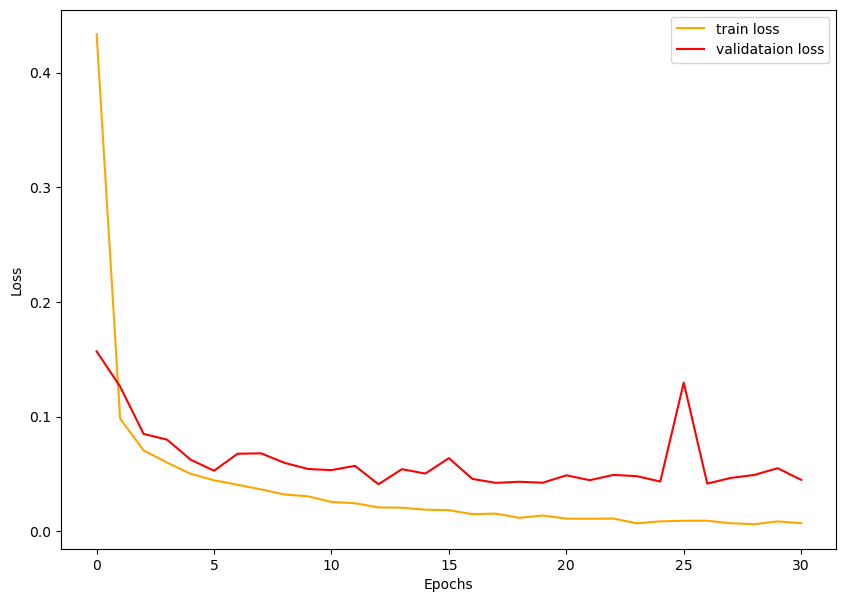

In [42]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
Path('models/mathnet'+str(IMAGE_SIZE)+'/').mkdir(parents=True, exist_ok=True)
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
    torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

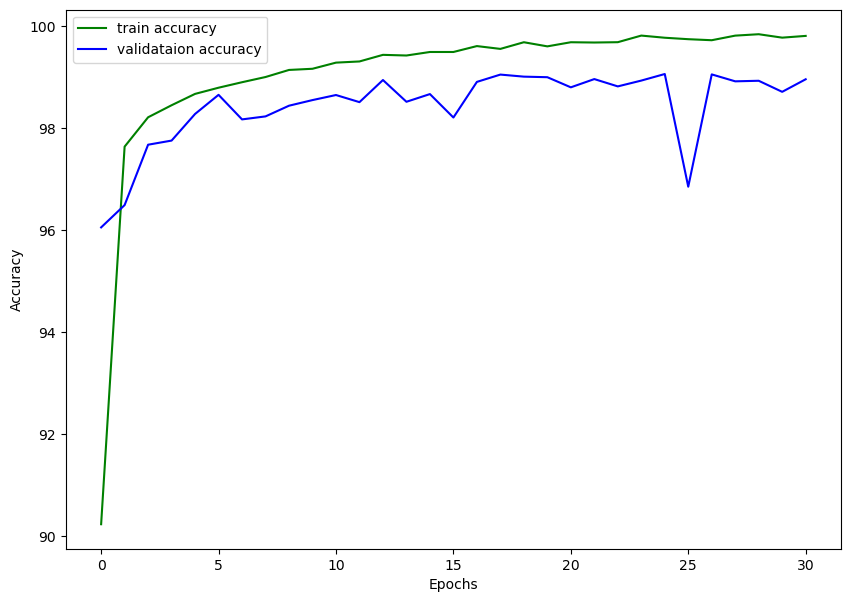

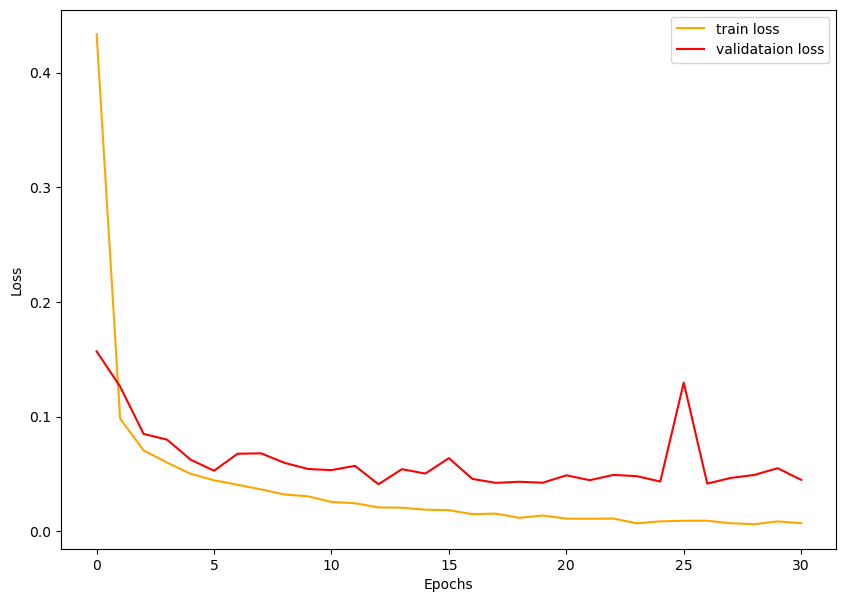

In [43]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


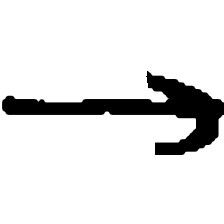

tensor([[ -56.0102,  -59.8779,  -75.9948,    2.3353,  -90.5763,  -96.7635,
         -105.9084,  -69.4088,  -77.8014, -106.1689, -126.8015,  -17.8973,
          -77.7565,  -79.3975,  -43.9408,  -37.6433,  -99.2526,  -88.5943,
          -45.1399,  -78.0319,  -52.5010,  -14.1318, -103.6707,  -61.8583,
           -2.2607,  -67.9374,  -72.6078,  -21.1769,  -58.2844,  -33.4514,
          -38.1844,  -84.5629,  -67.7118,  -53.7627,  -56.5316,   84.3884,
         -102.1432,  -66.2760,  -71.6315,  -50.8909,  -60.2604,  -89.0561,
          -64.2380,  -41.8228]], device='cuda:0', grad_fn=<MulBackward0>) rightarrow


In [44]:
import cv2
from PIL import Image, ImageOps

model.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = v2.Compose([
    v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    v2.Grayscale(1),
    v2.ToTensor()

])        
x_image = convert_tensor(img)

aaa = v2.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, mnt.map_pred(pred.argmax().item()))

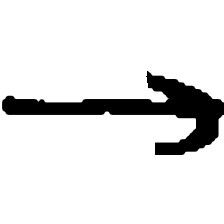

tensor([[-57.3511, -50.2911, -58.8966,   5.9123, -86.7741, -82.2904, -70.7250,
         -54.8159, -45.2668, -66.3012, -85.3547, -48.6963, -53.8681, -62.2272,
         -29.0388, -35.8226, -64.4931, -49.0026, -32.8154, -40.3498, -35.5459,
         -42.0268, -62.6657, -37.7230,  29.5240, -26.6283, -27.8127, -14.8912,
         -52.2286, -17.8137, -27.5664, -40.8129, -51.4280, -33.9072, -32.2290,
          85.6635, -52.7444, -44.1153, -50.4611,  13.4441, -19.0557, -58.6517,
         -34.9276, -35.5317]], device='cuda:0', grad_fn=<MulBackward0>) rightarrow


In [45]:
import cv2
from PIL import Image, ImageOps

m = mnt.MathNet()
m.load_state_dict(torch.load('T:\my_programs\Math_recognition\models\mathnet224'+'/mathnet8.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = v2.Compose([
    v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    v2.Grayscale(1),
    v2.ToTensor()

])        
x_image = convert_tensor(img)

aaa = v2.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, mnt.map_pred(pred.argmax().item()))